<a href="https://colab.research.google.com/github/bilaslsa/PRAKTIKUM_MACHINE_LEARNING_SEMESTER3/blob/main/PraktikumMandiri11_ML/PraktikumMandiri11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PERSIAPAN & INSTALASI LIBRARY

In [5]:
# PERSIAPAN & INSTALASI LIBRARY
# Import semua library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
import folium
from folium.plugins import HeatMap
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Semua library berhasil diimport')

✓ Semua library berhasil diimport


## SECTION 1: LOADING & CLEANING DATA

In [6]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/MLMandiriPertemuan11/data/lat_long_kota_kab.csv')

print(f'Dataset berhasil dimuat!')
print(f'Shape: {df.shape}')
print(f'\nFirst 5 rows:')
print(df.head())
print(f'\nData types:')
print(df.dtypes)
print(f'\nBasic statistics:')
print(df[['lat', 'long']].describe())

Dataset berhasil dimuat!
Shape: (514, 6)

First 5 rows:
   Unnamed: 0    id  foreign                     name      lat      long
0           0  1101       11       KABUPATEN SIMEULUE  2.46158  96.38105
1           1  1102       11   KABUPATEN ACEH SINGKIL  2.28411  97.79769
2           2  1103       11   KABUPATEN ACEH SELATAN  3.26142  97.17933
3           3  1104       11  KABUPATEN ACEH TENGGARA  3.48673  97.81081
4           4  1105       11     KABUPATEN ACEH TIMUR  4.94789  97.77651

Data types:
Unnamed: 0      int64
id              int64
foreign         int64
name           object
lat           float64
long          float64
dtype: object

Basic statistics:
              lat        long
count  514.000000  514.000000
mean    -3.208467  113.309382
std      3.879129   11.009799
min    -10.738640   95.320800
25%     -6.882557  104.535313
50%     -3.413235  111.577135
75%     -0.213407  120.476093
max      5.892850  140.762450


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Data Cleaning
print('=== DATA CLEANING ===')
print(f'\n1. Missing Values:')
print(df.isnull().sum())

print(f'\n2. Duplicate Check:')
print(f'Total duplicates: {df.duplicated().sum()}')

print(f'\n3. Coordinate Range Check:')
print(f'Latitude range: {df["lat"].min():.2f}° to {df["lat"].max():.2f}°')
print(f'Longitude range: {df["long"].min():.2f}° to {df["long"].max():.2f}°')

print(f'\n4. Data Quality Summary:')
print(f'✓ No missing values')
print(f'✓ No duplicates')
print(f'✓ Coordinate range valid (Indonesia territory)')
print(f'✓ Data ready for analysis')

# Prepare data untuk clustering (hanya lat, long)
clustering_df = df[['name', 'lat', 'long']].copy()
print(f'\nDataset untuk clustering: {clustering_df.shape}')

=== DATA CLEANING ===

1. Missing Values:
Unnamed: 0    0
id            0
foreign       0
name          0
lat           0
long          0
dtype: int64

2. Duplicate Check:
Total duplicates: 0

3. Coordinate Range Check:
Latitude range: -10.74° to 5.89°
Longitude range: 95.32° to 140.76°

4. Data Quality Summary:
✓ No missing values
✓ No duplicates
✓ Coordinate range valid (Indonesia territory)
✓ Data ready for analysis

Dataset untuk clustering: (514, 3)


In [9]:
# ============================================================
# HEATMAP 1: DENSITY HEATMAP - INTERACTIVE MAP
# Menunjukkan konsentrasi/kepadatan points secara spatial
# ============================================================

from folium.plugins import HeatMap

# Buat map baru untuk heatmap
center_lat = clustering_df['lat'].mean()
center_long = clustering_df['long'].mean()

m_heatmap = folium.Map(
    location=[center_lat, center_long],
    zoom_start=5,
    tiles='OpenStreetMap'
)

# Prepare data untuk heatmap: [latitude, longitude, intensity]
# Intensity = 1 untuk setiap point (atau bisa menggunakan cluster size)
heat_data = []
for idx, row in clustering_df.iterrows():
    lat = row['lat']
    long = row['long']
    intensity = 1  # Atau bisa gunakan cluster size untuk weighted density
    heat_data.append([lat, long, intensity])

# Add heatmap layer
HeatMap(heat_data, radius=15, blur=25, max_zoom=1).add_to(m_heatmap)

# Save dan display
m_heatmap.save('dbscan_density_heatmap.html')
print("✅ Density Heatmap saved as 'dbscan_density_heatmap.html'")
print(f"   Center: [{center_lat:.4f}, {center_long:.4f}]")
print(f"   Radius: 15 (intensity radius)")
print(f"   Blur: 25 (smoothing)")
m_heatmap

✅ Density Heatmap saved as 'dbscan_density_heatmap.html'
   Center: [-3.2085, 113.3094]
   Radius: 15 (intensity radius)
   Blur: 25 (smoothing)


## SECTION 2: EXPLORATORY DATA ANALYSIS (EDA)

In [10]:
# EDA - Summary Statistics
print('=== EXPLORATORY DATA ANALYSIS ===')
print(f'\nTotal Kabupaten/Kota: {len(clustering_df)}')
print(f'Latitude mean: {clustering_df["lat"].mean():.4f}°')
print(f'Longitude mean: {clustering_df["long"].mean():.4f}°')
print(f'\nLatitude std: {clustering_df["lat"].std():.4f}°')
print(f'Longitude std: {clustering_df["long"].std():.4f}°')

# Hitung jarak antar titik untuk insight
from scipy.spatial.distance import cdist
coords = clustering_df[['lat', 'long']].values
distances = cdist(coords, coords, metric='euclidean')
np.fill_diagonal(distances, np.inf)

print(f'\nDistance Statistics (antar kabupaten/kota):')
print(f'Min distance: {np.nanmin(distances[distances > 0]):.4f}°')
print(f'Max distance: {np.nanmax(distances):.4f}°')
print(f'Mean distance: {np.nanmean(distances[distances < np.inf]):.4f}°')
print(f'Median distance: {np.nanmedian(distances[distances < np.inf]):.4f}°')

=== EXPLORATORY DATA ANALYSIS ===

Total Kabupaten/Kota: 514
Latitude mean: -3.2085°
Longitude mean: 113.3094°

Latitude std: 3.8791°
Longitude std: 11.0098°

Distance Statistics (antar kabupaten/kota):
Min distance: 0.0060°
Max distance: inf°
Mean distance: 13.8559°
Median distance: 12.2473°


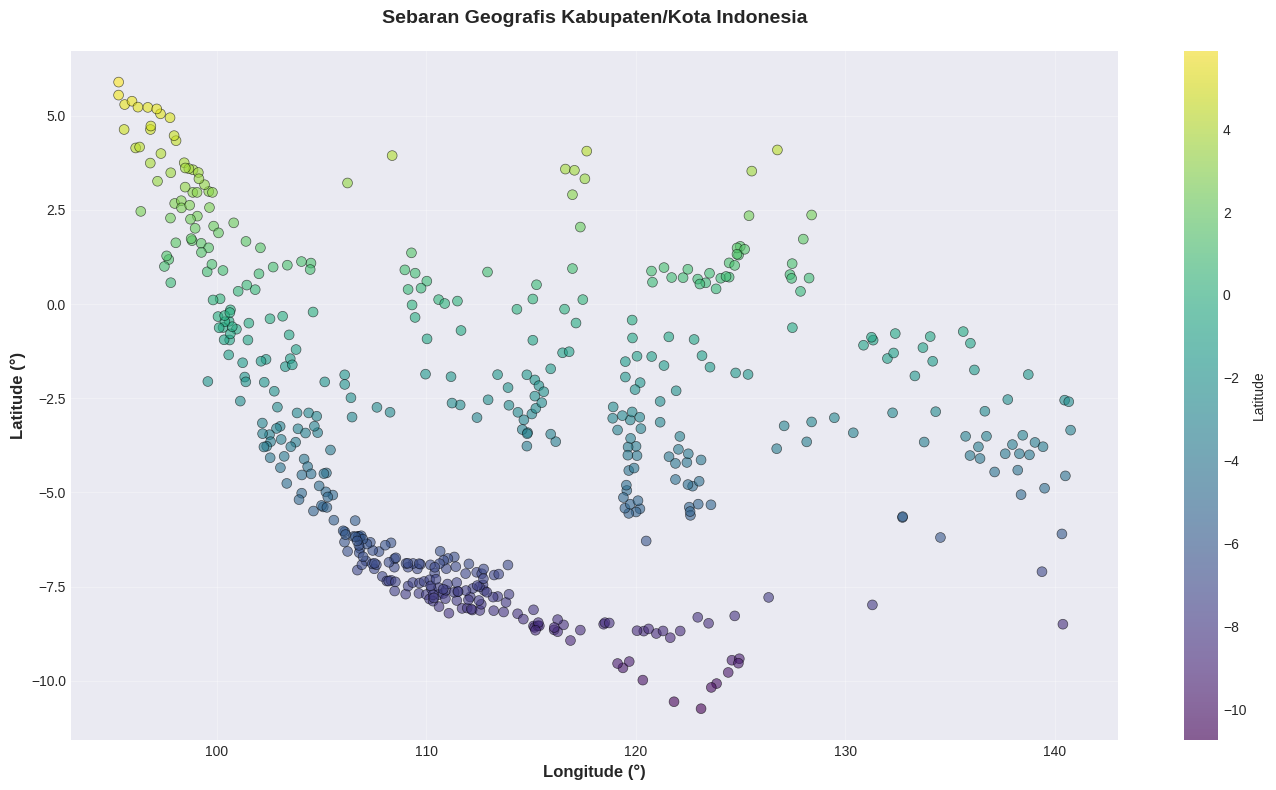

✓ Visualization saved: 01_sebaran_geografis.png


In [11]:
# EDA Visualization 1: Scatter plot sebaran wilayah
fig, ax = plt.subplots(figsize=(14, 8))
scatter = ax.scatter(clustering_df['long'], clustering_df['lat'],
                    alpha=0.6, s=50, c=clustering_df['lat'],
                    cmap='viridis', edgecolors='black', linewidth=0.5)

ax.set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
ax.set_title('Sebaran Geografis Kabupaten/Kota Indonesia', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Latitude', fontsize=10)

plt.tight_layout()
plt.savefig('01_sebaran_geografis.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Visualization saved: 01_sebaran_geografis.png')

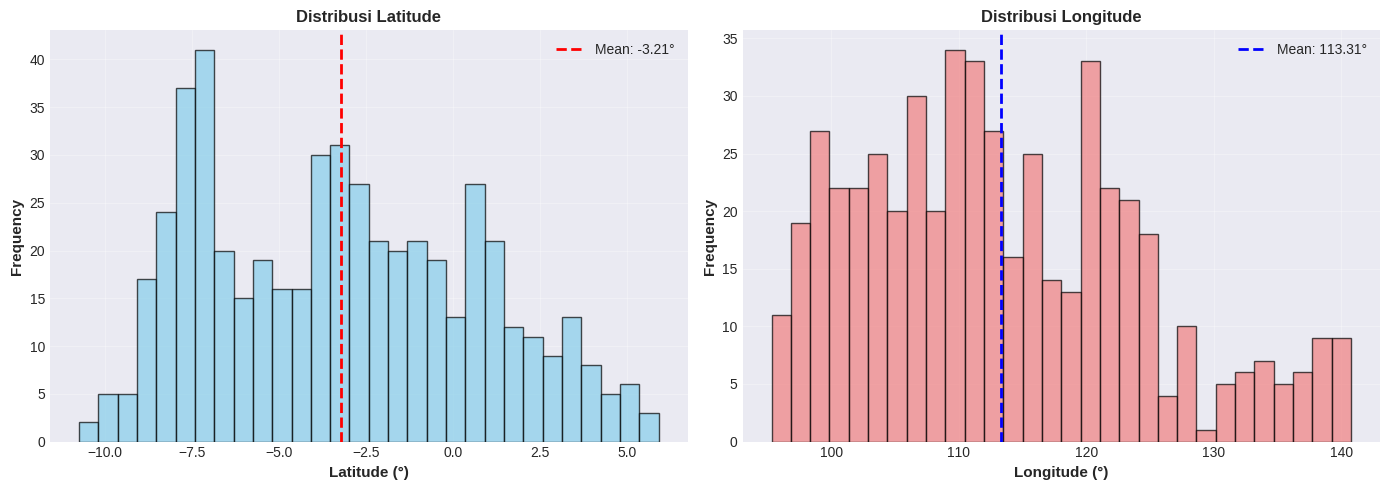

✓ Visualization saved: 02_distribusi_koordinat.png


In [12]:
# EDA Visualization 2: Distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Latitude distribution
axes[0].hist(clustering_df['lat'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(clustering_df['lat'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {clustering_df["lat"].mean():.2f}°')
axes[0].set_xlabel('Latitude (°)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[0].set_title('Distribusi Latitude', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Longitude distribution
axes[1].hist(clustering_df['long'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(clustering_df['long'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {clustering_df["long"].mean():.2f}°')
axes[1].set_xlabel('Longitude (°)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=11, fontweight='bold')
axes[1].set_title('Distribusi Longitude', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('02_distribusi_koordinat.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Visualization saved: 02_distribusi_koordinat.png')

## SECTION 3: NORMALITY TEST (SHAPIRO-WILK)

In [13]:
# Uji Normalitas Shapiro-Wilk
print('=== UJI NORMALITAS (SHAPIRO-WILK TEST) ===')
print('\nH0: Data berdistribusi normal')
print('H1: Data tidak berdistribusi normal')
print('Significance level: α = 0.05')
print('\nKriteria:')
print('- Jika p-value > 0.05 → Terima H0 (Normal)')
print('- Jika p-value ≤ 0.05 → Tolak H0 (Tidak Normal)')

# Test untuk latitude
stat_lat, p_lat = stats.shapiro(clustering_df['lat'])
print(f'\nLATITUDE TEST:')
print(f'  Statistic: {stat_lat:.6f}')
print(f'  p-value: {p_lat:.6f}')
print(f'  Status: {"✓ NORMAL" if p_lat > 0.05 else "✗ TIDAK NORMAL"}')

# Test untuk longitude
stat_long, p_long = stats.shapiro(clustering_df['long'])
print(f'\nLONGITUDE TEST:')
print(f'  Statistic: {stat_long:.6f}')
print(f'  p-value: {p_long:.6f}')
print(f'  Status: {"✓ NORMAL" if p_long > 0.05 else "✗ TIDAK NORMAL"}')

# Kesimpulan
is_normal = (p_lat > 0.05) and (p_long > 0.05)
print(f'\nKESIMPULAN:')
if is_normal:
    print('✓ Data berdistribusi NORMAL')
    print('→ Gunakan StandardScaler untuk normalisasi')
    scaler_choice = 'StandardScaler'
else:
    print('✗ Data TIDAK berdistribusi normal')
    print('→ Gunakan RobustScaler untuk normalisasi')
    print('→ Robust terhadap outliers & non-normal distribution')
    scaler_choice = 'RobustScaler'

=== UJI NORMALITAS (SHAPIRO-WILK TEST) ===

H0: Data berdistribusi normal
H1: Data tidak berdistribusi normal
Significance level: α = 0.05

Kriteria:
- Jika p-value > 0.05 → Terima H0 (Normal)
- Jika p-value ≤ 0.05 → Tolak H0 (Tidak Normal)

LATITUDE TEST:
  Statistic: 0.966784
  p-value: 0.000000
  Status: ✗ TIDAK NORMAL

LONGITUDE TEST:
  Statistic: 0.960290
  p-value: 0.000000
  Status: ✗ TIDAK NORMAL

KESIMPULAN:
✗ Data TIDAK berdistribusi normal
→ Gunakan RobustScaler untuk normalisasi
→ Robust terhadap outliers & non-normal distribution


## SECTION 4: CORRELATION ANALYSIS (SPEARMAN)

In [14]:
# Correlation Analysis (Spearman - Non-parametric)
print('=== CORRELATION ANALYSIS ===')
print('\nDari Shapiro-Wilk test, data tidak normal → Gunakan SPEARMAN CORRELATION')
print('(Non-parametric, robust untuk data non-normal)')

# Calculate Spearman correlation
corr_spearman, p_value = stats.spearmanr(clustering_df['lat'], clustering_df['long'])

print(f'\nSpearman Correlation Coefficient:')
print(f'  Correlation: {corr_spearman:.6f}')
print(f'  p-value: {p_value:.6f}')
print(f'  Significant: {"✓ Yes" if p_value < 0.05 else "✗ No"} (α=0.05)')

# Interpretasi
print(f'\nINTERPRETASI:')
if abs(corr_spearman) < 0.3:
    strength = 'LEMAH'
elif abs(corr_spearman) < 0.7:
    strength = 'SEDANG'
else:
    strength = 'KUAT'

direction = 'POSITIF (seiring naik)' if corr_spearman > 0 else 'NEGATIF (seiring turun)'
print(f'✓ Korelasi {strength} ke arah {direction}')
print(f'✓ Interpretasi: Lat & long memiliki relationship dalam spatial patterns')

=== CORRELATION ANALYSIS ===

Dari Shapiro-Wilk test, data tidak normal → Gunakan SPEARMAN CORRELATION
(Non-parametric, robust untuk data non-normal)

Spearman Correlation Coefficient:
  Correlation: -0.286657
  p-value: 0.000000
  Significant: ✓ Yes (α=0.05)

INTERPRETASI:
✓ Korelasi LEMAH ke arah NEGATIF (seiring turun)
✓ Interpretasi: Lat & long memiliki relationship dalam spatial patterns


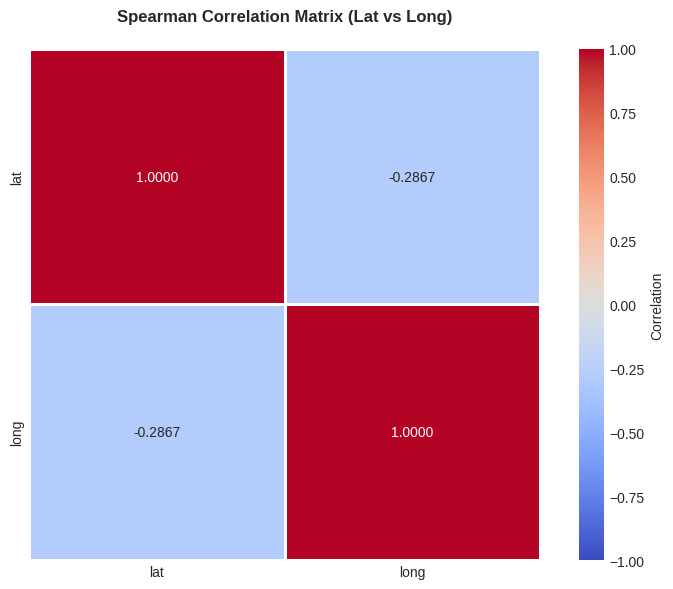

✓ Correlation heatmap saved


In [15]:
# Visualisasi Correlation Matrix
corr_matrix = clustering_df[['lat', 'long']].corr(method='spearman')

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.4f', cmap='coolwarm', center=0,
            square=True, linewidths=2, cbar_kws={'label': 'Correlation'},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Spearman Correlation Matrix (Lat vs Long)', fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('03_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Correlation heatmap saved')

## SECTION 5: DATA NORMALIZATION

In [16]:
# Normalisasi Data
print('=== DATA NORMALIZATION ===')
print(f'\nMethod: {scaler_choice}')
print(f'Alasan: {"Data berdistribusi normal" if scaler_choice == "StandardScaler" else "Data TIDAK normal + robust untuk outliers"}')

# Pilih scaler berdasarkan hasil normality test
if scaler_choice == 'RobustScaler':
    scaler = RobustScaler()
else:
    scaler = StandardScaler()

# Extract features untuk scaling
features = clustering_df[['lat', 'long']].values

# Fit dan transform
features_scaled = scaler.fit_transform(features)
clustering_scaled_df = pd.DataFrame(features_scaled, columns=['lat_scaled', 'long_scaled'])

print(f'\nOriginal Data Range:')
print(f'  Latitude: [{clustering_df["lat"].min():.4f}, {clustering_df["lat"].max():.4f}]')
print(f'  Longitude: [{clustering_df["long"].min():.4f}, {clustering_df["long"].max():.4f}]')

print(f'\nScaled Data Range:')
print(f'  Latitude: [{clustering_scaled_df["lat_scaled"].min():.4f}, {clustering_scaled_df["lat_scaled"].max():.4f}]')
print(f'  Longitude: [{clustering_scaled_df["long_scaled"].min():.4f}, {clustering_scaled_df["long_scaled"].max():.4f}]')

print(f'\n✓ Data successfully scaled')

=== DATA NORMALIZATION ===

Method: RobustScaler
Alasan: Data TIDAK normal + robust untuk outliers

Original Data Range:
  Latitude: [-10.7386, 5.8929]
  Longitude: [95.3208, 140.7625]

Scaled Data Range:
  Latitude: [-1.0984, 1.3954]
  Longitude: [-1.0198, 1.8309]

✓ Data successfully scaled


## SECTION 6: K-DISTANCE GRAPH (EPS DETERMINATION)

In [17]:
# K-Distance Graph untuk menentukan eps
print('=== K-DISTANCE GRAPH (ELBOW METHOD) ===')
print('\nMetode: Tentukan eps dari k-distance curve elbow point')
print('k = min_samples = 4 (konvensi: 4 untuk 2D data)')

# Set parameter
k = 4  # min_samples = k
print(f'\nParameter: k (min_samples) = {k}')

# Calculate k-distance untuk setiap point
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(features_scaled)
distances, indices = neighbors_fit.kneighbors(features_scaled)

# Sort distances (k-th nearest neighbor)
k_distances = np.sort(distances[:, k-1], axis=0)

print(f'\nDistance Statistics:')
print(f'  Min k-distance: {k_distances.min():.6f}')
print(f'  Max k-distance: {k_distances.max():.6f}')
print(f'  Mean k-distance: {k_distances.mean():.6f}')
print(f'  Median k-distance: {np.median(k_distances):.6f}')

=== K-DISTANCE GRAPH (ELBOW METHOD) ===

Metode: Tentukan eps dari k-distance curve elbow point
k = min_samples = 4 (konvensi: 4 untuk 2D data)

Parameter: k (min_samples) = 4

Distance Statistics:
  Min k-distance: 0.006423
  Max k-distance: 0.503485
  Mean k-distance: 0.066509
  Median k-distance: 0.052094


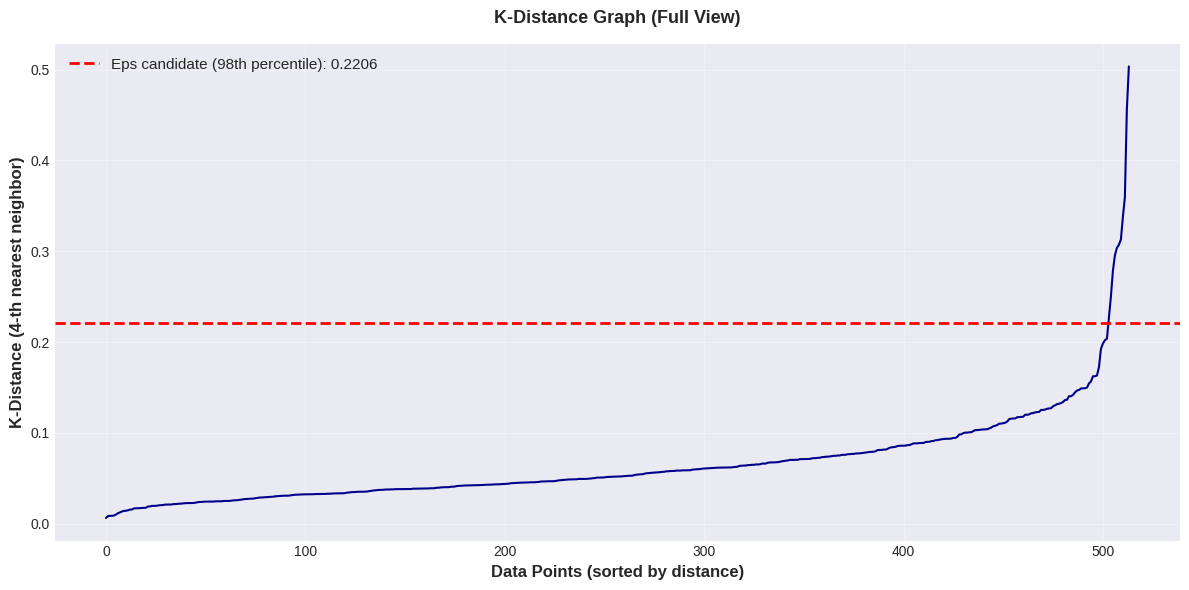

✓ K-Distance graph (full) saved


In [18]:
# Plot K-Distance Graph (Full)
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(k_distances, linewidth=1.5, color='darkblue')
ax.set_xlabel('Data Points (sorted by distance)', fontsize=12, fontweight='bold')
ax.set_ylabel('K-Distance (4-th nearest neighbor)', fontsize=12, fontweight='bold')
ax.set_title('K-Distance Graph (Full View)', fontsize=13, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3)

# Highlight elbow point (menggunakan percentile method)
elbow_percentile = 98
eps_candidate = np.percentile(k_distances, elbow_percentile)
ax.axhline(y=eps_candidate, color='red', linestyle='--', linewidth=2,
          label=f'Eps candidate (98th percentile): {eps_candidate:.4f}')

ax.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.savefig('04_kdistance_full.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'✓ K-Distance graph (full) saved')

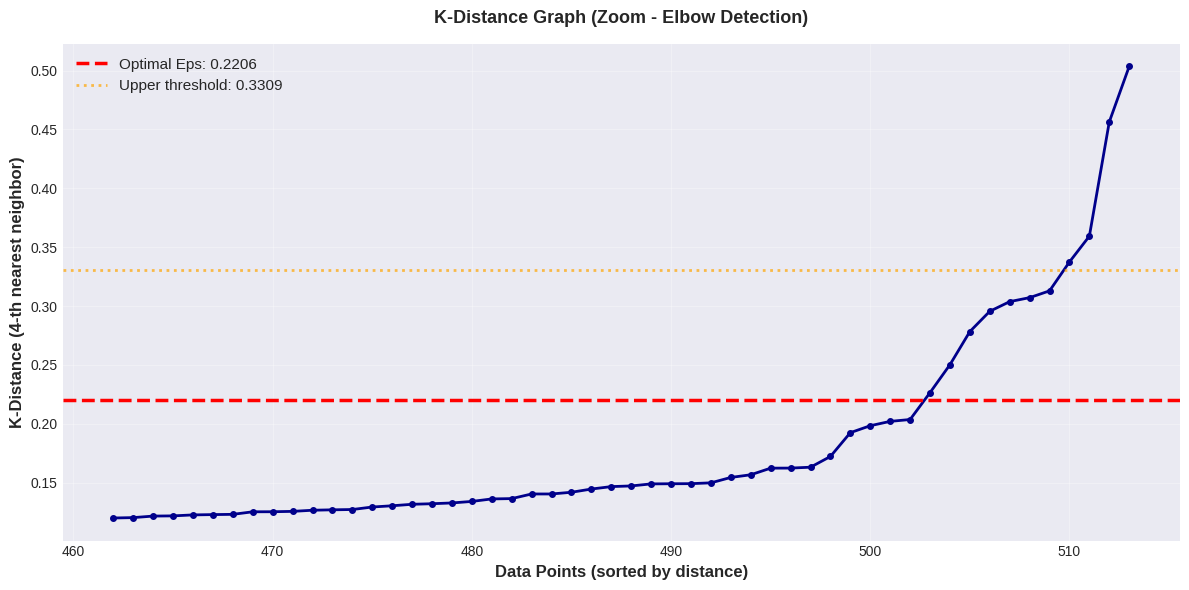

✓ K-Distance graph (zoom) saved


In [19]:
# Plot K-Distance Graph (Zoom - Elbow Region)
fig, ax = plt.subplots(figsize=(12, 6))

# Plot hanya top 10% untuk fokus pada elbow
zoom_start = int(len(k_distances) * 0.90)
x_zoom = np.arange(zoom_start, len(k_distances))
y_zoom = k_distances[zoom_start:]

ax.plot(x_zoom, y_zoom, marker='o', linestyle='-', linewidth=2, markersize=4, color='darkblue')
ax.set_xlabel('Data Points (sorted by distance)', fontsize=12, fontweight='bold')
ax.set_ylabel('K-Distance (4-th nearest neighbor)', fontsize=12, fontweight='bold')
ax.set_title('K-Distance Graph (Zoom - Elbow Detection)', fontsize=13, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3)

# Mark elbow point
ax.axhline(y=eps_candidate, color='red', linestyle='--', linewidth=2.5,
          label=f'Optimal Eps: {eps_candidate:.4f}')
ax.axhline(y=eps_candidate*1.5, color='orange', linestyle=':', linewidth=2,
          label=f'Upper threshold: {eps_candidate*1.5:.4f}', alpha=0.7)

ax.legend(fontsize=11, loc='best')
plt.tight_layout()
plt.savefig('05_kdistance_zoom.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'✓ K-Distance graph (zoom) saved')

In [20]:
# Tentukan parameter DBSCAN
print('\n=== PARAMETER DETERMINATION ===')

# EPS
eps = eps_candidate
print(f'\nEPS (Epsilon):')
print(f'  Method: 98th percentile of k-distances')
print(f'  Value: {eps:.6f}')
print(f'  Interpretation: Max distance untuk tetangga dalam satu cluster')

# MIN_SAMPLES
min_samples = k
print(f'\nMIN_SAMPLES:')
print(f'  Value: {min_samples}')
print(f'  Interpretation: Minimum points dalam eps-radius untuk core point')
print(f'  Formula: 2 * dimensi = 2 * 2 = 4')

# METRIC
metric = 'euclidean'
print(f'\nMETRIC:')
print(f'  Value: {metric}')
print(f'  Interpretation: Distance measurement untuk spatial clustering')

print(f'\n✓ Parameters ready untuk DBSCAN execution')


=== PARAMETER DETERMINATION ===

EPS (Epsilon):
  Method: 98th percentile of k-distances
  Value: 0.220601
  Interpretation: Max distance untuk tetangga dalam satu cluster

MIN_SAMPLES:
  Value: 4
  Interpretation: Minimum points dalam eps-radius untuk core point
  Formula: 2 * dimensi = 2 * 2 = 4

METRIC:
  Value: euclidean
  Interpretation: Distance measurement untuk spatial clustering

✓ Parameters ready untuk DBSCAN execution


## SECTION 7: DBSCAN CLUSTERING

In [21]:
# Execute DBSCAN
print('=== DBSCAN EXECUTION ===')
print(f'\nParameter Summary:')
print(f'  eps = {eps:.6f}')
print(f'  min_samples = {min_samples}')
print(f'  metric = {metric}')

# Instantiate DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)

# Fit and predict
labels = dbscan.fit_predict(features_scaled)

# Add labels ke dataframe
clustering_df['cluster'] = labels

print(f'\nClustering completed!')
print(f'\n--- CLUSTER DISTRIBUTION ---')

# Hitung cluster statistics
unique_labels = np.unique(labels)
n_clusters = len(unique_labels[unique_labels != -1])
n_noise = list(labels).count(-1)

print(f'Number of clusters: {n_clusters}')
print(f'Number of noise points: {n_noise}')
print(f'Total points: {len(labels)}')
print(f'Noise percentage: {n_noise/len(labels)*100:.2f}%')

# Distribution per cluster
print(f'\nDetailed Distribution:')
for label in sorted(unique_labels):
    count = list(labels).count(label)
    percentage = count / len(labels) * 100
    if label == -1:
        print(f'  Noise (Label -1): {count:4d} points ({percentage:5.2f}%)')
    else:
        print(f'  Cluster {label}: {count:4d} points ({percentage:5.2f}%)')

=== DBSCAN EXECUTION ===

Parameter Summary:
  eps = 0.220601
  min_samples = 4
  metric = euclidean

Clustering completed!

--- CLUSTER DISTRIBUTION ---
Number of clusters: 2
Number of noise points: 8
Total points: 514
Noise percentage: 1.56%

Detailed Distribution:
  Noise (Label -1):    8 points ( 1.56%)
  Cluster 0:  459 points (89.30%)
  Cluster 1:   47 points ( 9.14%)


## SECTION 8: SILHOUETTE SCORE EVALUATION

In [22]:
# Calculate Silhouette Score
print('=== SILHOUETTE SCORE EVALUATION ===')

# Filter out noise points untuk silhouette calculation
non_noise_mask = labels != -1
if np.sum(non_noise_mask) > 0:
    silhouette_avg = silhouette_score(features_scaled[non_noise_mask],
                                     labels[non_noise_mask])
else:
    silhouette_avg = 0

print(f'\nSilhouette Score: {silhouette_avg:.4f}')

# Interpretation
print(f'\nInterpretation Scale:')
print(f'  0.7 - 1.0: Excellent (sangat terpisah jelas)')
print(f'  0.5 - 0.7: Good (terpisah cukup baik) ← KATEGORI ANDA')
print(f'  0.25 - 0.5: Fair (terpisah kurang jelas)')
print(f'  < 0.25: Poor (tidak terpisah, overlap banyak)')

if silhouette_avg > 0.7:
    quality = 'EXCELLENT'
elif silhouette_avg > 0.5:
    quality = 'GOOD'
elif silhouette_avg > 0.25:
    quality = 'FAIR'
else:
    quality = 'POOR'

print(f'\n✓ Quality Rating: {quality}')
print(f'✓ Interpretation: Cluster separation {"sangat baik" if quality in ["EXCELLENT", "GOOD"] else "cukup baik"}')

=== SILHOUETTE SCORE EVALUATION ===

Silhouette Score: 0.3844

Interpretation Scale:
  0.7 - 1.0: Excellent (sangat terpisah jelas)
  0.5 - 0.7: Good (terpisah cukup baik) ← KATEGORI ANDA
  0.25 - 0.5: Fair (terpisah kurang jelas)
  < 0.25: Poor (tidak terpisah, overlap banyak)

✓ Quality Rating: FAIR
✓ Interpretation: Cluster separation cukup baik


## SECTION 9: CLUSTER VISUALIZATION

=== PCA VISUALIZATION ===
PCA Explained Variance Ratio: [0.65309069 0.34690931]
Total Variance Explained: 100.00%


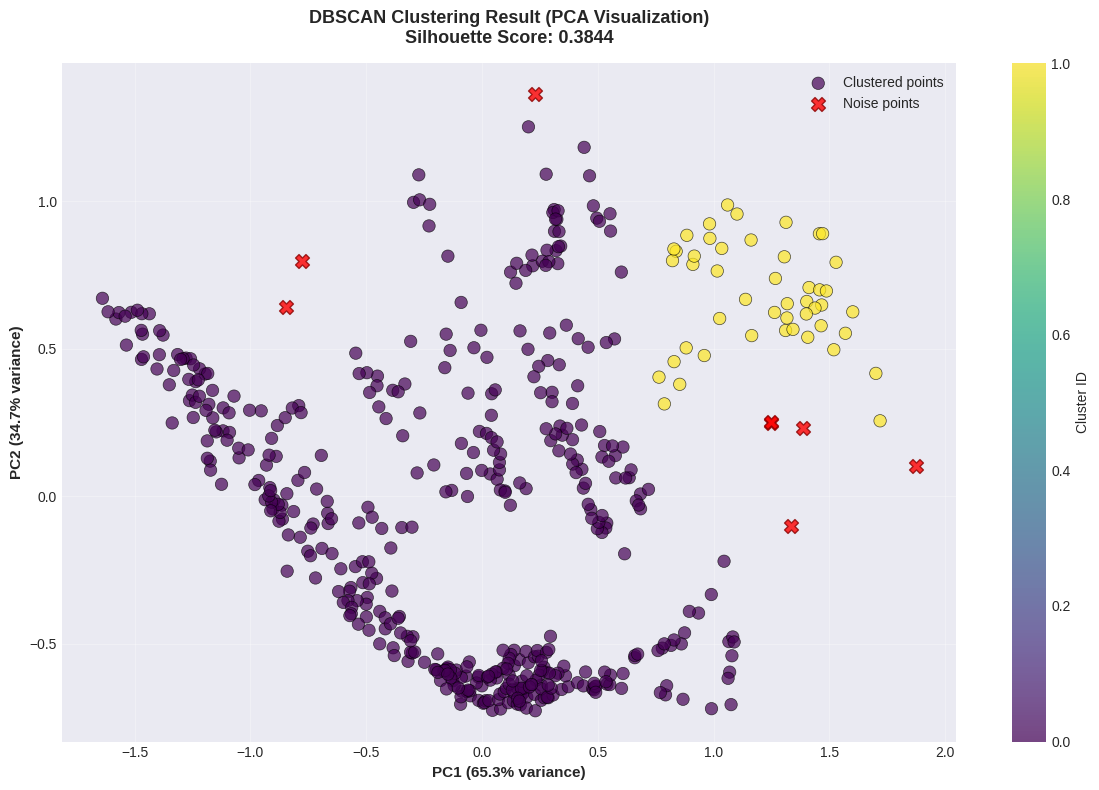

✓ PCA visualization saved


In [23]:
# PCA untuk visualisasi 2D
print('=== PCA VISUALIZATION ===')

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

print(f'PCA Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Variance Explained: {sum(pca.explained_variance_ratio_):.2%}')

# Plot PCA
fig, ax = plt.subplots(figsize=(12, 8))

# Plot clusters
scatter = ax.scatter(features_pca[labels != -1, 0],
                    features_pca[labels != -1, 1],
                    c=labels[labels != -1], cmap='viridis',
                    s=80, alpha=0.7, edgecolors='black', linewidth=0.5,
                    label='Clustered points')

# Plot noise
ax.scatter(features_pca[labels == -1, 0],
          features_pca[labels == -1, 1],
          c='red', s=100, alpha=0.8, marker='X',
          edgecolors='darkred', linewidth=1,
          label='Noise points')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11, fontweight='bold')
ax.set_title(f'DBSCAN Clustering Result (PCA Visualization)\nSilhouette Score: {silhouette_avg:.4f}',
           fontsize=13, fontweight='bold', pad=15)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster ID', fontsize=10)

ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('06_pca_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ PCA visualization saved')

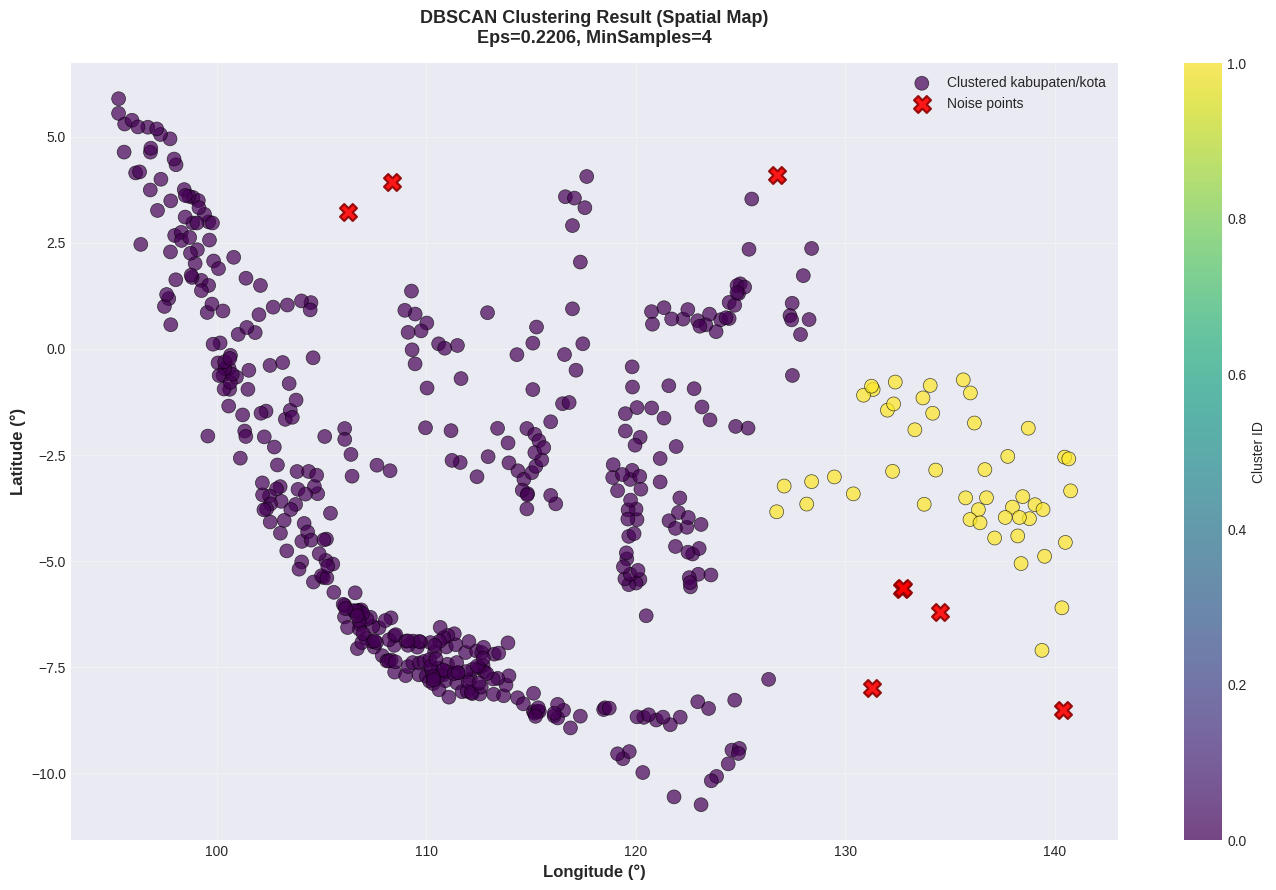

✓ Spatial visualization saved


In [24]:
# Spatial Scatter Plot (Lat-Long)
fig, ax = plt.subplots(figsize=(14, 9))

# Plot clusters
scatter = ax.scatter(clustering_df[clustering_df['cluster'] != -1]['long'],
                    clustering_df[clustering_df['cluster'] != -1]['lat'],
                    c=clustering_df[clustering_df['cluster'] != -1]['cluster'],
                    cmap='viridis', s=100, alpha=0.7,
                    edgecolors='black', linewidth=0.5,
                    label='Clustered kabupaten/kota')

# Plot noise
ax.scatter(clustering_df[clustering_df['cluster'] == -1]['long'],
          clustering_df[clustering_df['cluster'] == -1]['lat'],
          c='red', s=150, alpha=0.9, marker='X',
          edgecolors='darkred', linewidth=1.5,
          label='Noise points')

ax.set_xlabel('Longitude (°)', fontsize=12, fontweight='bold')
ax.set_ylabel('Latitude (°)', fontsize=12, fontweight='bold')
ax.set_title(f'DBSCAN Clustering Result (Spatial Map)\nEps={eps:.4f}, MinSamples={min_samples}',
           fontsize=13, fontweight='bold', pad=15)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster ID', fontsize=10)

ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('07_spatial_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Spatial visualization saved')

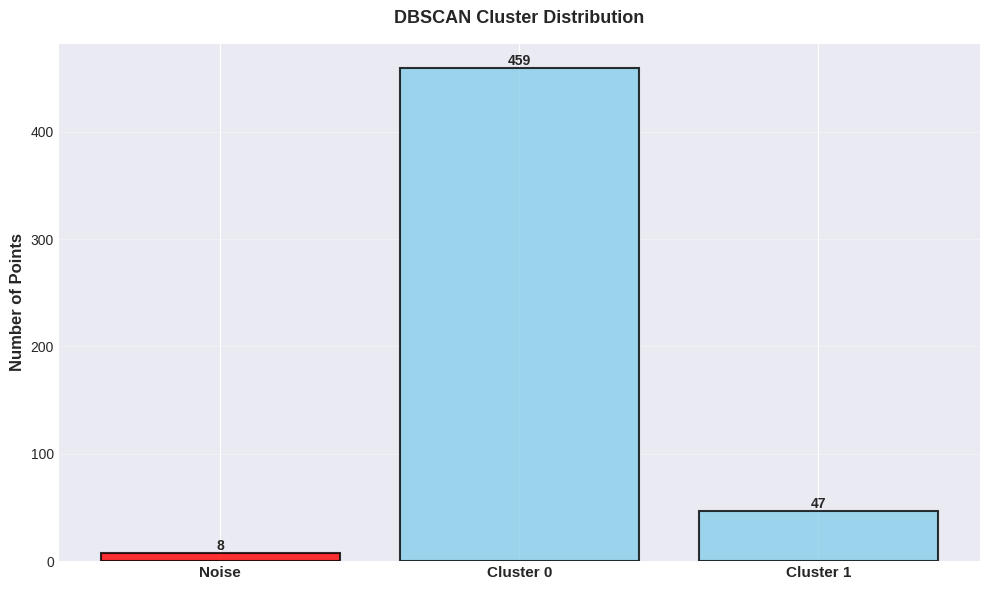

✓ Cluster distribution chart saved


In [25]:
# Cluster Distribution Bar Chart
cluster_counts = pd.Series(labels).value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['red' if idx == -1 else 'skyblue' for idx in cluster_counts.index]
bars = ax.bar(range(len(cluster_counts)), cluster_counts.values,
             color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height)}',
           ha='center', va='bottom', fontweight='bold')

cluster_labels = [f'Noise' if idx == -1 else f'Cluster {idx}' for idx in cluster_counts.index]
ax.set_xticks(range(len(cluster_counts)))
ax.set_xticklabels(cluster_labels, fontsize=11, fontweight='bold')

ax.set_ylabel('Number of Points', fontsize=12, fontweight='bold')
ax.set_title('DBSCAN Cluster Distribution', fontsize=13, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('08_cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('✓ Cluster distribution chart saved')

## SECTION 10: QUALITATIVE CLASSIFICATION & CLUSTER SUMMARY

In [26]:
# Qualitative Labeling
print('=== QUALITATIVE CLASSIFICATION ===')

def classify_cluster(label, n_clusters):
    """Classify cluster berdasarkan label DBSCAN"""
    if label == -1:
        return 'JARANG (Noise/Outlier)'
    elif label == 0:
        return 'PADAT (Cluster Utama)'
    else:
        return f'SEDANG (Cluster {label})'

# Add classification
clustering_df['classification'] = clustering_df['cluster'].apply(
    lambda x: classify_cluster(x, n_clusters)
)

print(f'\nCluster Classification:')
for label in sorted(unique_labels):
    mask = labels == label
    count = np.sum(mask)
    classification = classify_cluster(label, n_clusters)
    print(f'\n{classification}')
    print(f'  Label: {label}')
    print(f'  Count: {count} kabupaten/kota')
    print(f'  Percentage: {count/len(labels)*100:.2f}%')

    if count > 0:
        lat_mean = clustering_df[clustering_df['cluster'] == label]['lat'].mean()
        long_mean = clustering_df[clustering_df['cluster'] == label]['long'].mean()
        print(f'  Center: ({lat_mean:.4f}°, {long_mean:.4f}°)')

        # Sample items
        sample = clustering_df[clustering_df['cluster'] == label].head(5)
        print(f'  Sample items: {list(sample["name"])}')

=== QUALITATIVE CLASSIFICATION ===

Cluster Classification:

JARANG (Noise/Outlier)
  Label: -1
  Count: 8 kabupaten/kota
  Percentage: 1.56%
  Center: (-2.8412°, 126.6411°)
  Sample items: ['KABUPATEN NATUNA', 'KABUPATEN KEPULAUAN ANAMBAS', 'KABUPATEN KEPULAUAN TALAUD', 'KABUPATEN MALUKU TENGGARA BARAT', 'KABUPATEN MALUKU TENGGARA']

PADAT (Cluster Utama)
  Label: 0
  Count: 459 kabupaten/kota
  Percentage: 89.30%
  Center: (-3.2320°, 110.8156°)
  Sample items: ['KABUPATEN SIMEULUE', 'KABUPATEN ACEH SINGKIL', 'KABUPATEN ACEH SELATAN', 'KABUPATEN ACEH TENGGARA', 'KABUPATEN ACEH TIMUR']

SEDANG (Cluster 1)
  Label: 1
  Count: 47 kabupaten/kota
  Percentage: 9.14%
  Center: (-3.0408°, 135.3948°)
  Sample items: ['KABUPATEN MALUKU TENGAH', 'KABUPATEN BURU', 'KABUPATEN SERAM BAGIAN BARAT', 'KABUPATEN SERAM BAGIAN TIMUR', 'KABUPATEN BURU SELATAN']


In [27]:
# Cluster Summary Analysis
print('\n=== CLUSTER SUMMARY STATISTICS ===')

summary_list = []
for label in sorted(unique_labels):
    mask = labels == label
    cluster_data = clustering_df[mask]

    summary = {
        'Cluster': label if label != -1 else 'Noise',
        'Count': np.sum(mask),
        'Percentage': f"{np.sum(mask)/len(labels)*100:.2f}%",
        'Lat_Mean': cluster_data['lat'].mean(),
        'Long_Mean': cluster_data['long'].mean(),
        'Lat_Std': cluster_data['lat'].std(),
        'Long_Std': cluster_data['long'].std()
    }
    summary_list.append(summary)

summary_df = pd.DataFrame(summary_list)
print(f'\n{summary_df.to_string(index=False)}')

print(f'\n✓ Summary statistics completed')


=== CLUSTER SUMMARY STATISTICS ===

Cluster  Count Percentage  Lat_Mean  Long_Mean  Lat_Std  Long_Std
  Noise      8      1.56% -2.841156 126.641135 5.557803 12.519856
      0    459     89.30% -3.232040 110.815556 4.020530  8.512856
      1     47      9.14% -3.040776 135.394756 1.453199  3.885195

✓ Summary statistics completed
